# Identificaci√≥n de tendencias con trendet y comparaci√≥n de sentimiento con el comportamiento del mercado con datos de investpy y twipper

**por √Ålvaro Bartolom√© del Canto @ alvarob96 en GitHub**

---
## Introducci√≥n

En este informe se presenta el resultado del estudio realizado combinando los paquetes de Python [trendet](https://github.com/alvarob96/trendet) y [twipper](https://github.com/alvarob96/twipper), para la detecci√≥n de tendencias en series temporales de datos hist√≥ricos de una acci√≥n y para la recuperaci√≥n de tweets a trav√©s de la API de Twitter desde Python, respectivamente.

---
## Caso de Estudio - Endesa

Se utilizar√° **trendet** para identificar tendencias en la serie temporal del √∫ltimo a√±o de una empresa, en este caso se propone el caso de estudio con **Endesa**, que es una empresa espa√±ola que opera en los sectores el√©ctrico y gas√≠stico. Una vez identificadas las tendencias a lo largo de los datos hist√≥ricos de cierre del √∫ltimo a√±o de ENDESA, se procede a la recuperaci√≥n de los tweets publicados desde Espa√±a y en espa√±ol entre las fechas entre las que se comprende dicha tendencia, a trav√©s de la b√∫squeda en la API Premium de Twitter, a trav√©s de **twipper**.

In [1]:
import trendet

In [2]:
(trendet.__author__, trendet.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.5')

In [3]:
import twipper

In [4]:
(twipper.__author__, twipper.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.1.3')

Se utilizar√° la funci√≥n `identify_all_trends` de **trendet** para identificar todas las tendencias que se dan a lo largo de los datos hist√≥ricos de **Endesa** en el per√≠odo comprendido entre 2018 y 2019, siempre que la tendencia dure m√°s de 5 d√≠as, es decir, una semana de mercado ya que solo son h√°biles los d√≠as de lunes a viernes. 

In [72]:
df = trendet.identify_all_trends(equity='bankia',
                                 country='spain',
                                 from_date='01/01/2018',
                                 to_date='01/01/2019',
                                 window_size=5)

In [73]:
df.head()

Open   High    Low  Close   Volume Currency Up Trend Down Trend
Date                                                                        
2018-01-02  4.000  4.053  3.990  4.041  3900000      EUR        A        NaN
2018-01-03  4.057  4.064  4.038  4.051  3020000      EUR        A        NaN
2018-01-04  4.074  4.133  4.064  4.110  5180000      EUR        A        NaN
2018-01-05  4.125  4.146  4.122  4.132  4690000      EUR        A        NaN
2018-01-08  4.145  4.168  4.095  4.104  3350000      EUR        A        NaN

Una vez se han identificado las tendencias y se dispone del `pandas.DataFrame` resultante del c√°lculo de dichas tendencias, se procede a la identificaci√≥n de las mismas sobre una gr√°fica de una serie temporal. De este modo, se podr√°n visualizar las tendencias identificadas para determinar cual o cuales ser√°n las tendencias a estudiar junto con los datos recuperados de Twitter.

In [74]:
up_trends = df['Up Trend'].dropna().unique().tolist()

In [75]:
down_trends = df['Down Trend'].dropna().unique().tolist()

In [76]:
df.reset_index(inplace=True)

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

Anotar que para la visualizaci√≥n se har√° uso del estilo creado por [@Dih5](https://github.com/Dih5) llamado [paper-themes](https://github.com/Dih5/paper-themes) para la visualizaci√≥n de gr√°ficas con [matplotlib](https://matplotlib.org/), pensado para publicaciones cient√≠ficas.

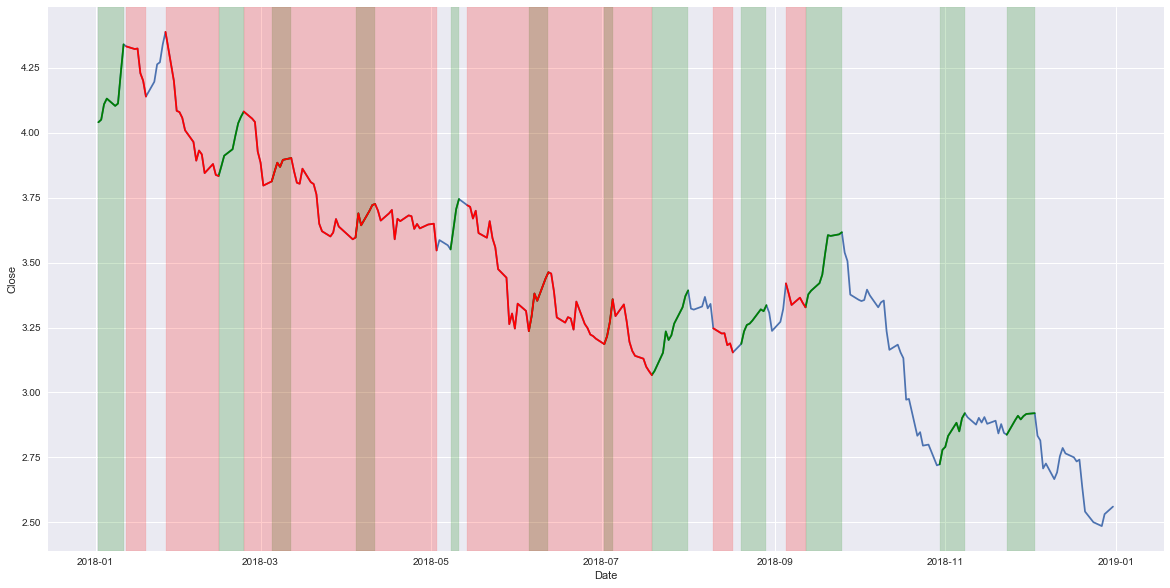

In [78]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(20, 10))

    ax = sns.lineplot(x=df['Date'], y=df['Close'])

    labels = df['Up Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Up Trend'] == label]['Date'],
                     y=df[df['Up Trend'] == label]['Close'],
                     color='green')

        ax.axvspan(df[df['Up Trend'] == label]['Date'].iloc[0],
                   df[df['Up Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='green')

    labels = df['Down Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Down Trend'] == label]['Date'],
                     y=df[df['Down Trend'] == label]['Close'],
                     color='red')

        ax.axvspan(df[df['Down Trend'] == label]['Date'].iloc[0],
                   df[df['Down Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='red')

    plt.show()

Tras mostrar las tendencias en forma de gr√°fica e identificar que las tendencias predominantes son las bajistas, se proceder√° a la identificaci√≥n de los intervalos de cada una de ellas con el fin de ver c√∫al ha tenido m√°s impacto sobre el valor en bolsa de Endesa, para as√≠ poder llevar dicha franja temporal a estudio con los datos de Twitter de Endesa.

In [13]:
for down_trend in down_trends:
    print(df[df['Down Trend'] == down_trend]['Date'].tolist()[0].strftime('%Y%m%d%H%S'),
          df[df['Down Trend'] == down_trend]['Date'].tolist()[-1].strftime('%Y%m%d%H%S'))
    print(df[df['Down Trend'] == down_trend]['Close'].tolist()[0],
          df[df['Down Trend'] == down_trend]['Close'].tolist()[-1])

201802010000 201802090000
17.97 16.6
201803190000 201803230000
17.39 17.115
201805230000 201805310000
19.95 18.845
201807180000 201807240000
19.87 19.37


La tendencia a analizar es la que corresponde al periodo comprendido entre: **'201802010000'** y **'201802090000'**. En este caso es una tendencia bajista, en la que el mercado cambia de manera abrupta de una forma muy negativa, bajando su valor en bolsa de '17.97' a '16.6', en un periodo de tan solo 7 d√≠as.

De este modo, ahora a partir de la informaci√≥n de Twitter extraida a trav√©s de [twipper](https://github.com/alvarob96/twipper/) se pretende analizar el impacto de la opini√≥n volcada en Twitter por los usuarios analizando su sentimiento, con el fin de determinar si afecta de un modo negativo al comportamiento del mercado y, as√≠ de alg√∫n modo, condiciona el mismo. Lo cual implica la utilizaci√≥n del modelo, creado previamente, para el an√°lisis de sentimientos en positivo, negativo o neutral de una colecci√≥n de tweets de entrada dada.

Destacar que para la recuperaci√≥n de tweets hist√≥ricos en una franja temporal determinada se requiere el uso de la API Premium de Twitter, ya que la versi√≥n gratuita tan solo da acceso a datos hist√≥ricos de los √∫ltimos 7 d√≠as, con lo que no es viable el uso de la versi√≥n gratuita de la misma.

In [14]:
cred = twipper.Twipper(consumer_key='Si1dJus1cp3YefEzGsnbLh37u',
                       consumer_secret='vDoaKZ49J2IfCO9BeM8hWONPd0AF00wxfQ16ilhKlEKz66pqZv',
                       access_token='894988499526590464-axe4Lj1pATPMLpIrxpAdw38HnOodYaf',
                       access_token_secret='4aNUPWEdIoSz0E2mZe9ywYxyDL8orWWufLgEvaOrhHfWt')

In [15]:
cred.plan = 'fullarchive'
cred.label = 'research'

Se har√° uso tambi√©n de una funcionalidad adicional implementada por **twipper**, que consiste en el formateo de queries del formato especificado y estandarizado por **twipper**, al formato de Twitter, que es distinto para las b√∫squedas batch o en streaming. Por tanto, al no tener un formato unificado, hace que la utilidad implementada por **twipper** sea de gran utilidad.

In [16]:
from twipper.utils import standard_query

In [17]:
query = standard_query('endesa OR endesa AND electricidad OR endesa AND gas')

In [20]:
query

'endesa OR endesa electricidad OR endesa gas'

In [21]:
from twipper.premium import search_tweets

In [22]:
tweets = search_tweets(access=cred,
                       query=query,
                       page_count=2,
                       from_date='201802010000',
                       to_date='201802090000',
                       language='es',
                       filter_retweets=False)

In [23]:
len(tweets)

200

In [33]:
unseen_tweets = list()

In [34]:
for tweet in tweets:
    if 'retweeted_status' in tweet:
        continue
    elif 'extended_tweet' in tweet:
        unseen_tweets.append(tweet['extended_tweet']['full_text'])
    else:
        unseen_tweets.append(tweet['text'])

In [35]:
len(unseen_tweets)

53

In [45]:
unseen_tweets[:5]

['https://t.co/6knegziosA\n\nDarse de baja de Endesa',
 'Endesa y Gas Natural Fenosa realizan la primera transacci√≥n de energ√≠a con tecnolog√≠a‚Ä¶ https://t.co/fJnErfbt7K',
 'Uno de los retos de la #empresa saludable seg√∫n @miriamfillesa @endesa #JCorrSalud https://t.co/OhMJ3Uus4v',
 'Anna Monta√±ana hace historia al convertirse en entrenadora ayudante de un equipo de la ACB https://t.co/gR0xjlGINW v√≠a @publico_es',
 'Anna Monta√±ana, al Fuenla: primera mujer en un cuerpo t√©cnico ACB https://t.co/1ar8RZHLZu']

Ahora, dado que ya se ha explicado en el informe de [twipper-sentiment](https://github.com/alvarob96/tcue/blob/master/docs/tcue_sentiment.pdf), se proceder√° a la implementaci√≥n del sistema de preparaci√≥n de los datos de cara a aplicar el modelo creado en dicho informe. Por tanto, antes de proceder con este informe, se recomienda que se consulte antes el anterior informe.

In [37]:
def get_stopwords():
    stopwords_list = list()

    with open('resources/stopwords-es.txt', 'rt', encoding='utf-8') as stopwords:
        for stopword in stopwords.readlines():
            stopwords_list.append(stopword.strip())

        stopwords.close()
        
    return stopwords_list

In [38]:
import re

In [39]:
def tokenizer(tweet, stopwords_list):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_pattern = re.compile('[ ]{2,}')
    
    result = url_pattern.sub('', tweet)
    result = html_pattern.sub('', result)
    result = spaces_pattern.sub('', result)
    result = re.findall('\w+', result)
    
    result = ' '.join([word.lower() for word in result if word.lower() not in stopwords_list])
    
    return result

In [41]:
stopwords = get_stopwords()

In [42]:
tokenized_tweets = [tokenizer(unseen_tweet, stopwords) for unseen_tweet in unseen_tweets]

In [44]:
tokenized_tweets[:5]

['darse baja endesa',
 'endesa gas natural fenosa realizan transacci√≥n energ√≠a tecnolog√≠a',
 'retos empresa saludable miriamfillesa endesa jcorrsalud',
 'anna monta√±ana historia convertirse entrenadora ayudante equipo acbv√≠a publico_es',
 'anna monta√±ana fuenla mujer cuerpo t√©cnico acb']

Para proceder con la clasificaci√≥n de tweets en sentimientos, en este caso, para tweets nunca vistos por el modelo, se requerir√° de la carga tanto del vectorizador **TfidfVectorizer**, como del propio modelo de an√°lisis de sentimientos **RandomForestClassifier**, es decir, de `resources/tfidf.pickle` y de `resources/sentiment_model.pickle`, respectivamente.

In [50]:
import pickle

In [51]:
with open('resources/tfidf.pickle', 'rb') as file_:
    tfidf = pickle.load(file_)

In [52]:
with open('resources/sentiment_model.pickle', 'rb') as file_:
    sentiment_model = pickle.load(file_)

Una vez cargados, se vectorizar√°n los tweets tokenizados ya que es la entrada requerida por el modelo, que este a su vez clasificar√° cada uno de los tweets introducidos en una de las categor√≠as previamente mapeadas de la forma:

In [66]:
sentiment_codes = {
    -1: 'negative',
    0: 'neutral',
    1: 'positive',
}

In [54]:
unseen_features = tfidf.transform(tokenized_tweets).toarray()

In [56]:
unseen_prediction = sentiment_model.predict(unseen_features)

Ahora se procede a la creaci√≥n de un `pandas.DataFrame` cuyo objetivo es mostrar de una forma m√°s clara el resultado del an√°lisis de sentimiento realizado sobre los tweets publicados entre 01/02/2018 y 09/02/2018.

In [57]:
import pandas as pd

In [62]:
df = pd.DataFrame({
    'tweets': unseen_tweets,
    'tokenized_tweets': tokenized_tweets,
    'sentiment': unseen_prediction
})

In [64]:
df.head()

tweets  \
0  https://t.co/6knegziosA\n\nDarse de baja de En...   
1  Endesa y Gas Natural Fenosa realizan la primer...   
2  Uno de los retos de la #empresa saludable seg√∫...   
3  Anna Monta√±ana hace historia al convertirse en...   
4  Anna Monta√±ana, al Fuenla: primera mujer en un...   

                                    tokenized_tweets  sentiment  
0                                  darse baja endesa          0  
1  endesa gas natural fenosa realizan transacci√≥n...          0  
2  retos empresa saludable miriamfillesa endesa j...          0  
3  anna monta√±ana historia convertirse entrenador...          0  
4     anna monta√±ana fuenla mujer cuerpo t√©cnico acb          0

In [67]:
df = df.replace({'sentiment': sentiment_codes})

In [68]:
df.head()

tweets  \
0  https://t.co/6knegziosA\n\nDarse de baja de En...   
1  Endesa y Gas Natural Fenosa realizan la primer...   
2  Uno de los retos de la #empresa saludable seg√∫...   
3  Anna Monta√±ana hace historia al convertirse en...   
4  Anna Monta√±ana, al Fuenla: primera mujer en un...   

                                    tokenized_tweets sentiment  
0                                  darse baja endesa   neutral  
1  endesa gas natural fenosa realizan transacci√≥n...   neutral  
2  retos empresa saludable miriamfillesa endesa j...   neutral  
3  anna monta√±ana historia convertirse entrenador...   neutral  
4     anna monta√±ana fuenla mujer cuerpo t√©cnico acb   neutral

Dado que como se ha explicado previamente el dataset de tweets clasificados de forma manual no es a√∫n del todo completo debido a la gran cantidad de tweets neutrales que hay en Twitter, se determina que para poder establecer la correlaci√≥n o no entre la tendencia bajista del mercado y el an√°lisis de sentimiento de Twitter, se eliminar√°n o no se tendr√°n en cuenta los tweets neutrales.

In [69]:
df = df.drop(df[df['sentiment'] == 'neutral'].index)

In [71]:
df

tweets  \
10  @ETSIngenieria @Endesa @unisevilla @CienciaUS ...   
17  Las cosillas que me encuentro trabajando en En...   
19  üèÄ‚ôÄÔ∏èFelicitats a Anna Monta√±ana, primera dona a...   
20  @ASAJASEVILLA @fibesevilla @PhilHoganEU @mapam...   
21  Gracias a @Endesa y sus aver√≠as nocturnas, est...   
44  Enhorabuena @AnnaMontanana Te lo mereces. #Gra...   
51  SE ACERCA EL REGRESO DEL "TIT√ÅN"\n\nYa habr√≠a ...   

                                     tokenized_tweets sentiment  
10  etsingenieria endesa unisevilla cienciaus cons...  positive  
17               cosillas encuentro trabajando endesa  positive  
19  felicitats anna monta√±ana dona formar part equ...  positive  
20  asajasevilla fibesevilla philhoganeu mapamagob...  positive  
21  gracias endesa aver√≠as nocturnas semana ido ca...  positive  
44  enhorabuena annamontanana mereces granentrenad...  positive  
51  acerca regreso tit√°n fecha gustavo ay√≥n vuelva...  negative

Como se puede observar, el resultado del estudio no es el esperado, dado que tan solo hay un tweet negativo de entre los tweets no neutrales analizados, lo cual se debe a que Endesa, al ser la empresa patrocinadora de la Liga Endesa de Baloncesto en Espa√±a, coincide con que los tweets recuperados entre dichas fechas aluden a la celebraci√≥n de un triunfo de Anna Monta√±a, que fue una jugadora de baloncesto y es entrenadora espa√±ola de baloncesto.

---
## Conclusiones

Tal y como se ha podido observar, este caso de estudio no ha sido exitoso debido a que es d√≠ficil determinar el comportamiento de una empresa en bolsa, cuando el nombre de la misma empresa no alude directamente a la empresa sino a productos de esta. Con esto se buscar√° determinar en un futuro el como discernir entre tweets que pueden afectar o no a la empresa de tweets que s√≠, de modo que se pueda contrastar dicha informaci√≥n con las noticias, sucesos, etc.

El NLP en espa√±ol y, m√°s en concreto, el an√°lisis de sentimiento en opini√≥n en espa√±ol es un campo de la Inteligencia Artificial con un largo camino e investigaci√≥n por delante. El hecho de que no est√© tan desarrollado se debe a que en el NLP √∫nicamente, o al menos principalmente, se desarrollan y crean tanto soluciones como datasets en ingl√©s, con lo que hace del NLP en espa√±ol algo m√°s tedioso.

Adicionalmente, a modo de "Trabajo Futuro", se propone el uso de **Wikipedia** para recuperar la p√°gina de Endesa, de modo que las keywords de la b√∫squeda en Twitter sean m√°s refinadas y aludan no solo a la propia empresa, sino tambi√©n al sector en el que opera, o a las caracter√≠sticas del mismo.

---
## Licencia

MIT License

Copyright (c) 2019 √Ålvaro Bartolom√© del Canto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---
## Autor

**√Ålvaro Bartolom√© del Canto, 2018-2019**